# Fish spieces

The goal is to predict fish spieces based on fish attributes

In [3]:
%matplotlib inline
import util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display


### Load data

We are going to load data from kaggle and read it into pandas dataframe

In [4]:
# download and load data
data_path = util.download_kaggle_dataset_file("aungpyaeap/fish-market", "Fish.csv", "fish_market")
data = pd.read_csv(util.get_dataset_path("fish_market/Fish.csv"))

### Take a quick look into data structure

In [5]:
display(data.head())
display(data.describe())

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


array([[<AxesSubplot:title={'center':'Weight'}>,
        <AxesSubplot:title={'center':'Length1'}>],
       [<AxesSubplot:title={'center':'Length2'}>,
        <AxesSubplot:title={'center':'Length3'}>],
       [<AxesSubplot:title={'center':'Height'}>,
        <AxesSubplot:title={'center':'Width'}>]], dtype=object)

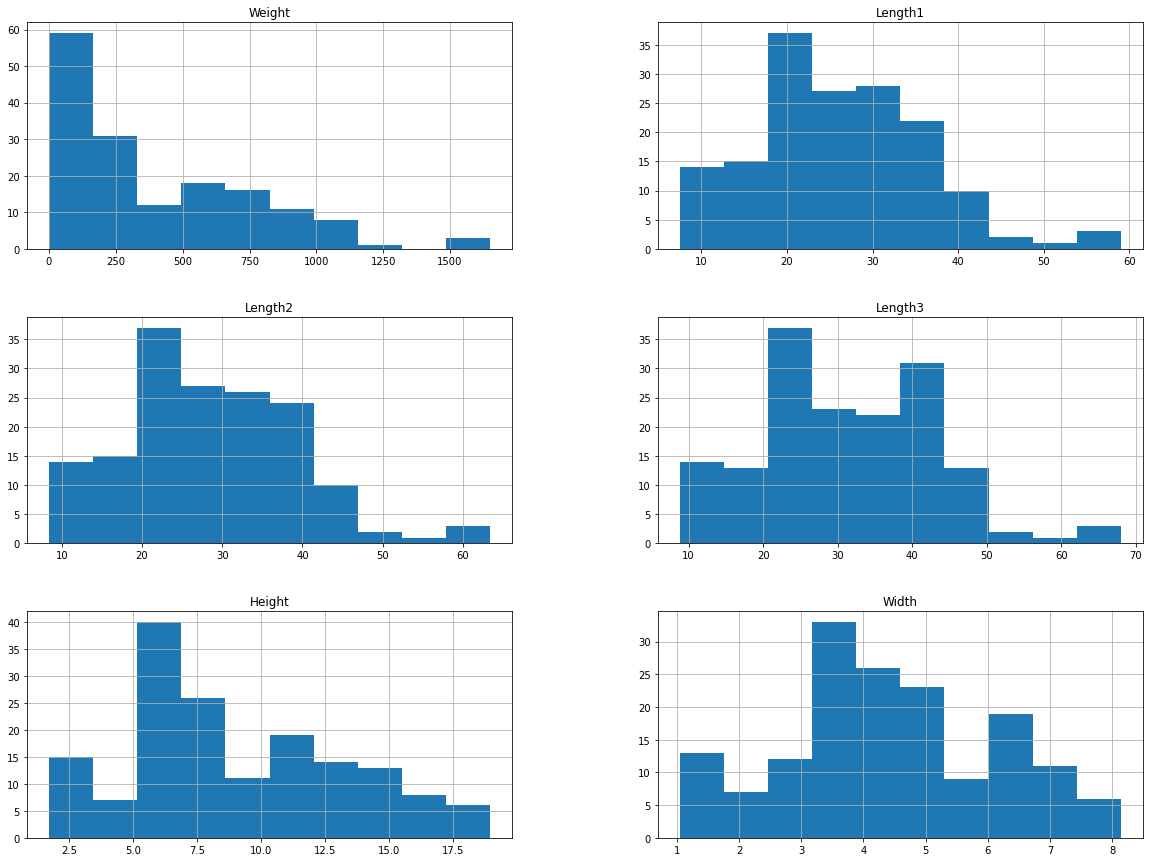

In [6]:
data.hist(figsize=(20,15))

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

<AxesSubplot:>

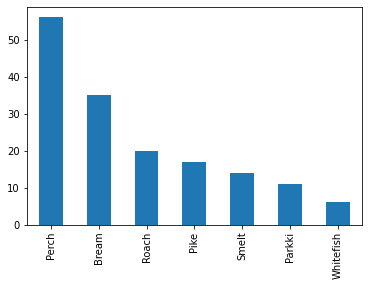

In [7]:
display(data["Species"].value_counts())
display(data["Species"].value_counts().plot.bar())

### Create test set

We are going to split data in test and train sets. This will make sure we set aside part of data, that we can use later for testing. We are going to use stratified sampling to guarantee that test set is representative of overall pupulation. This is because we can see that spieces we are trying to predict is non-uniformly distributed, this will make sure sampled test and train distributions have same distribution as initial distribution.

<AxesSubplot:>

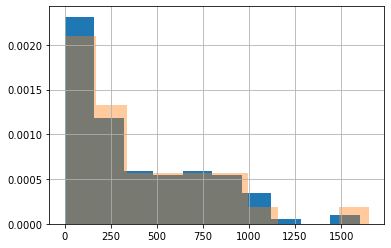

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

weight_cat = pd.cut(data.Weight,
    bins=np.append(np.arange(0, 1300, 100), np.inf),
    labels=np.arange(1, 14),
    include_lowest=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=43)
for train_index, test_index in split.split(data, weight_cat):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

train_set.Weight.hist(density=True, alpha=1)
test_set.Weight.hist(density=True, alpha=0.4)

<AxesSubplot:>

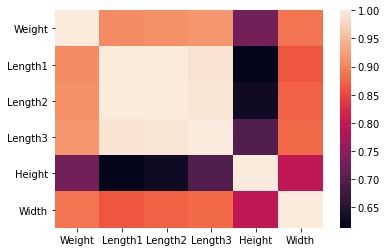

In [9]:
sns.heatmap(train_set.corr())

### Create attributes and labels

In [10]:
fish_attributes = train_set.drop("Weight", axis=1)
fish_labels = train_set.Weight.copy()

test_fish_attributes = test_set.drop("Weight", axis=1)
test_fish_labels = test_set.Weight.copy()

### Create processing pipeline

Creates a processing pipeline that for numeric values:

- fills in nan values
- scales values using standard scaler

For categorical columns:

- apply one hot encoding


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_columns = list(fish_attributes.select_dtypes(include=numerics))
cat_columns = list(fish_attributes.select_dtypes(exclude=numerics))

pipeline = ColumnTransformer([
    ('num', num_pipeline, num_columns),
    ('cat', OneHotEncoder(), cat_columns)
])

pipeline.fit(fish_attributes)

cat_encoder = pipeline.named_transformers_["cat"]
cat_one_hot_attributes = ["Spieces_"+c for c in list(cat_encoder.categories_[0])]

attributes = num_columns + cat_one_hot_attributes

### Transform train and test data using transformation pipeline

In [12]:
fish_attributes_prepared = pd.DataFrame(data=pipeline.transform(fish_attributes), columns=attributes)
test_fish_attributes_prepared = pd.DataFrame(data=pipeline.transform(test_fish_attributes), columns=attributes)

fish_attributes_prepared

,Length1,Length2,Length3,Height,Width,Spieces_Bream,Spieces_Parkki,Spieces_Perch,Spieces_Pike,Spieces_Roach,Spieces_Smelt,Spieces_Whitefish
0,0.951736,0.919153,0.818493,-0.397537,0.114967,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.202690,-0.167477,-0.157305,-0.198301,-0.083743,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.972308,-0.951740,-0.941428,-0.861433,-0.948133,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.334016,0.352215,0.530981,1.387616,0.475008,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.800156,-0.800557,-0.775891,-0.787297,-0.734338,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
122,-0.759650,-0.781659,-0.775891,-0.647687,-0.492251,0.0,0.0,0.0,0.0,1.0,0.0,0.0
123,1.134013,1.108132,1.079867,0.781944,1.295415,0.0,0.0,0.0,0.0,0.0,0.0,1.0
124,1.103634,1.108132,0.984030,0.788187,1.863314,0.0,0.0,1.0,0.0,0.0,0.0,0.0
125,-0.638132,-0.639925,-0.610354,0.172266,-0.744940,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Utility methods

- compute root mean square error
- compute 10-fold cross validation score
- plot predictions

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def compute_mse(predictions, labels):
    lin_mse = mean_squared_error(labels, predictions)
    lin_rmse = np.sqrt(lin_mse)

    return lin_rmse

def compute_cross_val_score(reg, attributes, labels):
    scores = cross_val_score(reg, attributes, labels, scoring="neg_mean_squared_error", cv=10)
    scores = np.sqrt(-scores)

    return scores, scores.mean(), scores.std()

def plot_predictions(predictions, labels):
    fig, ax = plt.subplots()
    ax.scatter(predictions, labels, edgecolors=(0, 0, 1))
    ax.plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'r--', lw=3)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    return fig

mean 116.0578391922558 std: 59.64180891916534


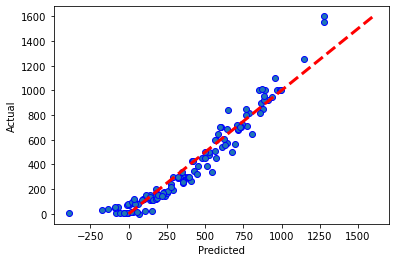

In [14]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(fish_attributes_prepared, fish_labels)

_, mean, std = compute_cross_val_score(lin_reg, fish_attributes_prepared, fish_labels)

fish_predictions = lin_reg.predict(fish_attributes_prepared)

plot_predictions(fish_predictions, fish_labels)
print("mean", mean, "std:", std)

mean 80.84076730074715 std: 27.87452786622423


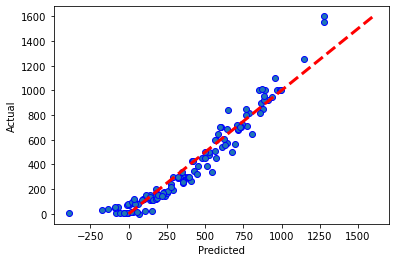

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(fish_attributes_prepared, fish_labels)

_, mean, std = compute_cross_val_score(tree_reg, fish_attributes_prepared, fish_labels)
fish_predictions = lin_reg.predict(fish_attributes_prepared)

plot_predictions(fish_predictions, fish_labels)
print("mean", mean, "std:", std)

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [1, 2, 3, 10, 30], 'max_features': [2, 4, 6, 8, 10]},
    {'bootstrap': [False], 'n_estimators': [1, 2, 3, 10], 'max_features': [2, 3, 4, 6]}
]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(fish_attributes_prepared, fish_labels)

#cvres = grid_search.cv_results_
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
#    print("mean score:", np.sqrt(-mean_score), "params:", params)

print("best score:", np.sqrt(-grid_search.best_score_), "best params:", grid_search.best_params_)

best score: 74.80542461304837 best params: {'bootstrap': False, 'max_features': 3, 'n_estimators': 2}


In [17]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = [
    {'learning_rate_init': uniform(0.001, 0.01),
     'alpha': uniform(0.0001, 0.01)}
]

mpl_regression = MLPRegressor(random_state=42, max_iter=1000, activation='relu', hidden_layer_sizes=(200, 200, 200), early_stopping=True)

random_search = RandomizedSearchCV(mpl_regression, param_dist, n_iter=5, cv=2, scoring='neg_mean_squared_error', return_train_score=True)
random_search.fit(fish_attributes_prepared, fish_labels)

print("best score:", np.sqrt(-random_search.best_score_), "best params:", random_search.best_params_)

best score: 71.55759341245688 best params: {'alpha': 0.005311667567604404, 'learning_rate_init': 0.005421881576445042}


41.715284032054726

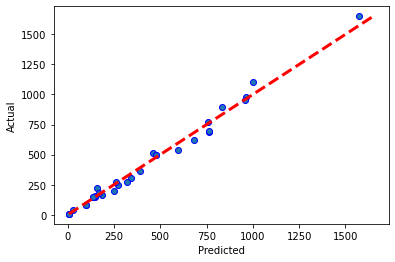

In [18]:
final_model = grid_search.best_estimator_

test_fish_predictions = final_model.predict(test_fish_attributes_prepared)
plot_predictions(test_fish_predictions, test_fish_labels)
compute_mse(test_fish_predictions, test_fish_labels)